# Load Data ( Positive images / Negative images /Annotation )

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

def load_images_from_folder(folder):
    images = []
    filenames = []
    original_sizes = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            original_size = img.shape[:2]  # Capture original size
            original_sizes.append(original_size)
            images.append(img)
            filenames.append(filename)
    return images, filenames, original_sizes

def load_annotations_from_folder(folder, filenames, target_size=(224, 224)):
    annotations = []
    for idx, filename in enumerate(filenames):
        annot_filename = os.path.splitext(filename)[0] + '.txt'
        annot_file = os.path.join(folder, annot_filename)
        boxes = []
        with open(annot_file, 'r') as file:
            for line in file.readlines():
                parts = line.replace('(', '').replace(')', '').replace(',', ' ').split()
                i = 0
                while i < len(parts) - 4:
                    try:
                        x_min = int(float(parts[i].strip()))
                        y_min = int(float(parts[i+1].strip()))
                        x_max = int(float(parts[i+2].strip()))
                        y_max = int(float(parts[i+3].strip()))
                        class_id = int(parts[i+4].strip())
                        boxes.append([x_min, y_min, x_max, y_max, class_id])
                        i += 10
                    except ValueError as e:
                        print(f"Error parsing line '{line}': {e}")
                        i += 10
        annotations.append(boxes)
    return annotations

# Setup directories
base_dir = '/content/drive/MyDrive/dataset'
positive_images_dir = os.path.join(base_dir, 'positive image set')
negative_images_dir = os.path.join(base_dir, 'negative image set')
ground_truth_dir = os.path.join(base_dir, 'ground truth')

# Load images and their original sizes
positive_images, positive_filenames, positive_original_sizes = load_images_from_folder(positive_images_dir)
negative_images, negative_filenames, negative_original_sizes = load_images_from_folder(negative_images_dir)
# Load annotations for positive images
positive_annotations = load_annotations_from_folder(ground_truth_dir, positive_filenames)

# Displaying some sample annotations to verify
for idx, annot in enumerate(positive_annotations[:5]):
    print(f"Annotations for image {idx + 1}: {annot}")

## Positive images with their respecting boundries

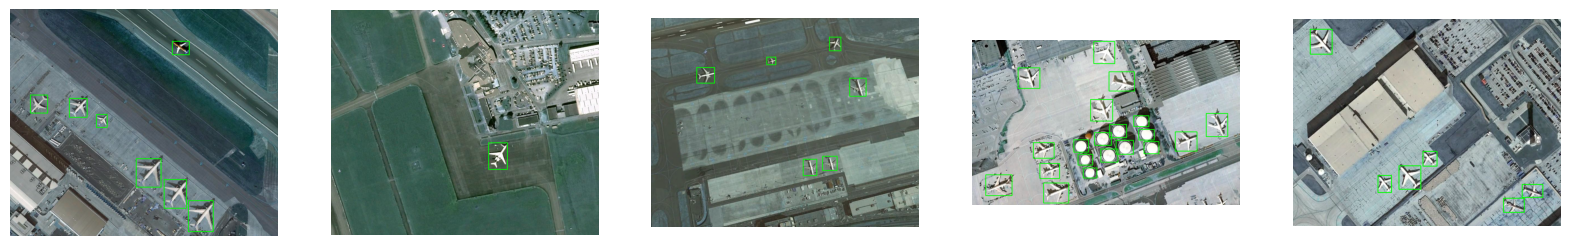

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Function to draw bounding boxes on images
def draw_boxes(img, boxes):
    for box in boxes:
        x_min, y_min, x_max, y_max, _ = box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    return img

# Example code to draw boxes on the first 5 augmented images
images_with_boxes = []
for img, annot in zip(positive_images[:5], positive_annotations[:5]):
    img_with_boxes = draw_boxes(img.copy(), annot)
    images_with_boxes.append(img_with_boxes)

# Now visualize the images with boxes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img in zip(axes, images_with_boxes):
    ax.imshow(img)
    ax.axis('off')
plt.show()


## resizing the images and respcting boundring for the target in the positive images

In [ ]:
import cv2

def resize_images(images, target_size=(1024, 1024)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return resized_images

def resize_annotations(annotations, original_sizes, target_size=(1024, 1024)):
    resized_annotations = []
    for idx, annot in enumerate(annotations):
        original_height, original_width = original_sizes[idx]
        scale_x = target_size[0] / original_width
        scale_y = target_size[1] / original_height
        resized_boxes = []
        for box in annot:
            x_min = int(box[0] * scale_x)
            y_min = int(box[1] * scale_y)
            x_max = int(box[2] * scale_x)
            y_max = int(box[3] * scale_y)
            class_id = box[4]
            resized_boxes.append([x_min, y_min, x_max, y_max, class_id])
        resized_annotations.append(resized_boxes)
    return resized_annotations

# Resizing positive images
target_size = (1024, 1024)  # Define your target size here
resized_positive_images = resize_images(positive_images, target_size)
resized_negative_images = resize_images(negative_images, target_size)

# Resizing positive annotations
resized_positive_annotations = resize_annotations(positive_annotations, positive_original_sizes, target_size)

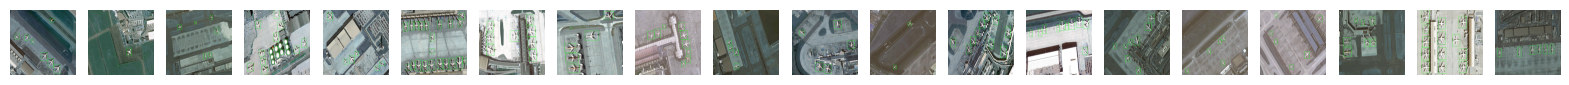

In [ ]:
import cv2

# Function to draw bounding boxes on images
def draw_boxes(img, boxes):
    for box in boxes:
        x_min, y_min, x_max, y_max, _ = box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    return img

# Example code to draw boxes on the first 5 augmented images
resized_images_with_boxes = []
for img, annot in zip(resized_positive_images[:20], resized_positive_annotations[:20]):
    img_with_boxes = draw_boxes(img.copy(), annot)
    resized_images_with_boxes.append(img_with_boxes)

# Now visualize the images with boxes
fig, axes = plt.subplots(1, 20, figsize=(20, 4))
for ax, img in zip(axes, resized_images_with_boxes):
    ax.imshow(img)
    ax.axis('off')
plt.show()


## Data augmentation on postive images

**Apply All Transformations to a Single Copy**

**Single Combined Augmentation:**

**Pros:** This method can be more efficient in terms of processing time and memory because it generates fewer augmented images. It simulates a more complex transformation that might occur in real-world scenarios, providing a robustness test for the model.

**Cons:** The downside is that it might introduce too much distortion, making it hard for the model to learn useful features. It can also lead to overfitting to specific patterns of combined augmentations if not managed carefully.
Apply Each Transformation to Separate Copies

**Multiple Individual Augmentations:**

**Pros:** This method allows the model to learn from a wider variety of simple changes, potentially improving its ability to generalize from each type of transformation individually. It increases the effective size of the training dataset more significantly, which can be beneficial for training deep learning models.

**Cons:** The main drawback is increased computational and storage requirements since you're generating multiple images for each original image in the dataset. It might also introduce redundancy if the transformations are too mild or too correlated.
Best Practices

**Balanced Approach:** Often, a mix of both strategies is employed. For example, you might apply mild transformations (like slight rotations and flips) individually to generate multiple images and then perform a few combined transformations (like moderate zoom followed by a slight rotation) to create more diverse scenarios.
Experimentation and Validation: It's important to experiment with different strategies and validate their impact on model performance. Monitoring how each type of augmentation affects overfitting, underfitting, and validation accuracy can guide you to optimize the augmentation pipeline.
Resource Management: Consider your computational resources and training time. More images mean longer training times and more disk space. If resources are limited, focusing on the most impactful transformations might be necessary.

# **Single Transformation:**
**Rotation + Horizontal Flip:** This combination can simulate the scenario where objects need to be recognized regardless of their orientation and reflection, which is common in environments where images can come from different perspectives or be mirrored, such as surveillance systems and certain types of automated monitoring.
    
# **Combinations:**
**Zoom + Brightness Adjustment:** This combination handles variations in both distance (zoom) and lighting conditions (brightness). This is particularly useful for applications like outdoor photography or security cameras, where both distance from the object and varying light conditions affect the quality and characteristics of captured images.

**Brightness Adjustment + Vertical Flip:** Combining lighting changes with a vertical flip can simulate conditions where objects might be viewed upside-down in varying light conditions, such as in underwater imaging or aerial photography where light reflections and orientation vary significantly.

**Zoom + Rotation:** This combination can effectively mimic the appearance of objects as they are seen from different distances and orientations. It's particularly useful in applications involving object detection from moving vehicles or drones, where both the distance to objects and their orientation relative to the camera can change quickly.

## Data Augemntation For Negative Imgaes

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_brightness_negative(image, brightness_factor):
    """ Adjust the brightness of an image. """
    return cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

def flip_horizontal_negative(image):
    """Flip image horizontally."""
    return cv2.flip(image, 1)  # 1 means horizontal flip

def flip_vertical_negative(image):
    """Flip image vertically."""
    return cv2.flip(image, 0)  # 0 means vertical flip

def generate_augmented_images_negative(original_img, zoom_factors, angles, brightness_factors):
    augmented_images = []

    # 1. Zoom + Rotation:
    zoom_factor = np.random.choice(zoom_factors)
    new_width = int(original_img.shape[1] * zoom_factor)
    new_height = int(original_img.shape[0] * zoom_factor)
    zoomed_rotation_img = cv2.resize(original_img, (new_width, new_height))
    start_x = (new_width - original_img.shape[1]) // 2
    start_y = (new_height - original_img.shape[0]) // 2
    zoomed_rotation_img = zoomed_rotation_img[start_y:start_y + original_img.shape[0], start_x:start_x + original_img.shape[1]]
    angle = np.random.choice(angles)
    zoomed_rotation_img = cv2.warpAffine(zoomed_rotation_img, cv2.getRotationMatrix2D((zoomed_rotation_img.shape[1] / 2, zoomed_rotation_img.shape[0] / 2), angle, 1), (zoomed_rotation_img.shape[1], zoomed_rotation_img.shape[0]))
    augmented_images.append(zoomed_rotation_img)

    # 2. Brightness Adjustment + Vertical Flip:
    v_flip_img = flip_vertical_negative(original_img)
    brightness_factor = np.random.choice(brightness_factors)
    v_flip_img = adjust_brightness_negative(v_flip_img, brightness_factor)
    augmented_images.append(v_flip_img)

    # 3. Zoom + Brightness Adjustment:
    zoom_factor = np.random.choice(zoom_factors)
    new_width = int(original_img.shape[1] * zoom_factor)
    new_height = int(original_img.shape[0] * zoom_factor)
    zoomed_brightness_img = cv2.resize(original_img, (new_width, new_height))
    start_x = (new_width - original_img.shape[1]) // 2
    start_y = (new_height - original_img.shape[0]) // 2
    zoomed_brightness_img = zoomed_brightness_img[start_y:start_y + original_img.shape[0], start_x:start_x + original_img.shape[1]]
    brightness_factor = np.random.choice(brightness_factors)
    zoomed_brightness_img = adjust_brightness_negative(zoomed_brightness_img, brightness_factor)
    augmented_images.append(zoomed_brightness_img)

    # Rotation augmentation
    angle = np.random.choice(angles)
    rotated_img = cv2.warpAffine(original_img, cv2.getRotationMatrix2D((original_img.shape[1] / 2, original_img.shape[0] / 2), angle, 1), (original_img.shape[1], original_img.shape[0]))
    augmented_images.append(rotated_img)

    # Horizontal Flip
    h_flip_img = flip_horizontal_negative(original_img)
    augmented_images.append(h_flip_img)

    return augmented_images

def display_augmentations_negative(original_img):
    zoom_factors = [1.2, 1.4, 1.6, 1.8, 2.0]  # Factors for zooming
    angles = [10, 20, 30, -10, -20, -30]       # Degrees for rotation
    brightness_factors = [0.5, 0.7, 1.3, 1.5]  # Factors for brightness adjustment

    aug_imgs = generate_augmented_images_negative(original_img, zoom_factors, angles, brightness_factors)
    fig, axes = plt.subplots(1, len(aug_imgs), figsize=(20, 5))  # Adding original image as well
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')

    for ax, img in zip(axes[1:], aug_imgs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (assuming you have resized_negative_images defined)
for img in resized_negative_images[:1]:  # Displaying first 5 images for example
    display_augmentations_negative(img)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is imported for image processing

# Initialize lists to hold all negative images
all_negative_images = []

# Iterate over each negative image
for img in resized_negative_images:

    zoom_factors = [1.2, 1.4, 1.6, 1.8, 2.0]  # Factors for zooming
    angles = [10, 20, 30, -10, -20, -30]       # Degrees for rotation
    brightness_factors = [0.5, 0.7, 1.3, 1.5]  # Factors for brightness adjustment
    # Generate augmented images
    augmented_images = generate_augmented_images_negative(img, zoom_factors, angles, brightness_factors)

    # Append the original image first
    all_negative_images.append(img)

    # Extend list with the augmented images
    all_negative_images.extend(augmented_images)

# Displaying the original and augmented images
fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # Adjust the subplot grid as necessary
for ax, img in zip(axes.flatten(), all_negative_images[:8]):  # Ensure we don't exceed the grid size
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the number of images in all_images
number_of_negative_images = len(all_negative_images)

# Print the result
print("Total number of images Negative images after data augmentation:", number_of_negative_images)

In [ ]:
import cv2
import os

def save_images(images, directory, base_filename="img"):
    """Saves images in the specified directory with sequential filenames."""
    if not os.path.exists(directory):
        os.makedirs(directory)
    for idx, image in enumerate(images):
        # Format filename (e.g., "001.jpg")
        filename = f"{idx+1:03d}.jpg"
        image_path = os.path.join(directory, filename)
        cv2.imwrite(image_path, image)
        print(f"Saved image: {image_path}")

def save_annotations(annotations, directory):
    """Saves annotations in text files with sequential filenames matching images."""
    if not os.path.exists(directory):
        os.makedirs(directory)
    for idx, annotation in enumerate(annotations):
        filename = f"{idx+1:03d}.txt"
        annotation_path = os.path.join(directory, filename)
        with open(annotation_path, 'w') as file:
            for box in annotation:
                # Format the annotation as per the specific requirements
                file.write(f"({box[0]},{box[1]}),({box[2]},{box[3]}),{box[4]}\n")
        print(f"Saved annotation: {annotation_path}")

annotation_dir = os.path.join(base_dir, 'annotations1')

# Example usage:
base_dir = 'C:\\Users\\azizk'
positive_image_dir = os.path.join(base_dir, 'positive_image_set1')
negative_image_dir = os.path.join(base_dir, 'negative_image_set1')
annotation_dir = os.path.join(base_dir, 'annotations1')

# Assume these lists are already filled with your data
# all_positive_images, all_positive_annotations, all_negative_images

save_images(all_positive_images, positive_image_dir)  # Saves positive images
save_annotations(all_positive_annotations, annotation_dir)  # Saves corresponding annotations
save_images(all_negative_images, negative_image_dir)  # Saves negative images


## Split Data

# **Load And Train ResNet50 Model**

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 502456, done.
remote: Counting objects: 100% (16066/16066), done.
remote: Compressing objects: 100% (806/806), done.
remote: Total 502456 (delta 15274), reused 16002 (delta 15233), pack-reused 486390
Receiving objects: 100% (502456/502456), 976.88 MiB | 34.49 MiB/s, done.
Resolving deltas: 100% (468518/468518), done.
fatal: not a git repository (or any of the parent directories): .git


In [3]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import numpy as np
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

from torchvision.transforms import functional as F

In [4]:
class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height,ID,CLASS,BOX, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.bbox_dir= bbox_dir
        self.height = height
        self.width = width
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = ID
        self.box=BOX
        self.Class=CLASS


        # classes: 0 index is reserved for background
        self.classes= [_,1,2,3,4,5,6,7,8,9,10]
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name +'.jpg')

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        #diving by 255
        img_res /= 255.0

        # annotation file
        annot_filename = img_name + '.txt'
        annot_file_path = os.path.join(self.bbox_dir, annot_filename)
        bb=[]
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        # convert boxes into a torch.Tensor
        bbox=self.box[idx]
        for box in bbox:
            xmin_corr = (box[0]/wt)*self.width
            xmax_corr = (box[2]/wt)*self.width
            ymin_corr = (box[1]/ht)*self.height
            ymax_corr = (box[3]/ht)*self.height
            bb.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(bb, dtype=torch.float32)
#         boxes = torch.as_tensor([xmin_corr, ymin_corr, xmax_corr, ymax_corr], dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(self.Class[idx], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id=idx
#         image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
#             print(img_res.shape)
#             print(target['boxes'])
#             print(labels.view(-1))
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels.view(-1))

            img_res = sample['image']
#             img_res = img_res.permute(1, 2, 0)
            target['boxes'] = torch.Tensor(sample['bboxes'])
            target["labels"] = labels.view(-1)
#             target['boxes'] = sample['bboxes']
#             print("---------------------------")
#             print(img_res.shape)
#             print(target['boxes'])
#             print(labels.view(-1))
#             print("----------------------------")
#         print(target)
        return torch.tensor(img_res), target

    def __len__(self):
        return len(self.imgs)

In [5]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/dataset2/positive image set'
neg_dir = '/content/drive/MyDrive/dataset2/negative image set'
bbox_dir = '/content/drive/MyDrive/dataset2/ground truth'
random_dir ='/kaggle/input/random-test'


In [7]:
def getressources():
        # Chemin vers votre répertoire contenant les fichiers
        repertoire = "/content/drive/MyDrive/dataset2/ground truth"

        # Initialisation des listes
        noms_fichiers = []
        box_data = []
        class_data = []

        # Parcours des fichiers dans le répertoire
        for nom_fichier in os.listdir(repertoire):
            chemin_fichier = os.path.join(repertoire, nom_fichier)
            # Vérification que le chemin correspond à un fichier et non à un répertoire
            if os.path.isfile(chemin_fichier):
                nom_sans_extension = os.path.splitext(nom_fichier)[0]
                with open(chemin_fichier, 'r') as f:
                    contenu_fichier = f.read()
                    noms_fichiers.append(nom_sans_extension)
                    lignes = contenu_fichier.strip().split('\n')
                    boxes = []
                    classes = []
                    for ligne in lignes:
                        elements = ligne.split(',')
                        box = [int(elem.strip("() ")) for elem in elements[:4]]
                        classe = int(elements[4])
                        boxes.append(box)
                        classes.append(classe)
                    box_data.append(boxes)
                    class_data.append(classes)

        # Création du DataFrame
#         data = {'ID': noms_fichiers, 'BOX': box_data, 'Class': class_data}
#         df = pd.DataFrame(data)
#         print(df.head())
#         C=[]
#         B=[]
#         I=[]
#         for index, rows in df.iterrows() :
#             Class=rows['Class']
#             Box=rows["BOX"]
#             ID=rows["ID"]
#             for i in range(len(Class)):
#                 B.append(Box[i])
#                 C.append(Class[i])
#                 I.append(ID)
#         data = {'ID': I, 'BOX': B, 'Class': C}
#         df = pd.DataFrame(data)
#         return(I,B,C)
        return(noms_fichiers,box_data,class_data)

In [8]:
ID,BOX,CLASS=getressources()

In [9]:
print(len(ID))

650


In [10]:
print(len(BOX))

650


In [11]:
print(len(CLASS))

650


In [12]:
# Transformation for image resizing and normalization
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# use our dataset and defined transformations
dataset = ImagesDataset(files_dir, 480, 480,ID,CLASS,BOX,transforms= get_transform(train=True))
dataset_test = ImagesDataset(files_dir, 480, 480,ID,CLASS,BOX,transforms= get_transform(train=False))



# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [15]:
# Model setup
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [20]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [21]:
device

device(type='cuda')

In [22]:
# training for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/104]  eta: 0:16:37  lr: 0.000053  loss: 2.2393 (2.2393)  loss_classifier: 1.5239 (1.5239)  loss_box_reg: 0.2636 (0.2636)  loss_objectness: 0.4305 (0.4305)  loss_rpn_box_reg: 0.0212 (0.0212)  time: 9.5881  data: 5.6167  max mem: 4357
Epoch: [0]  [ 10/104]  eta: 0:02:43  lr: 0.000538  loss: 1.6177 (1.5857)  loss_classifier: 1.2113 (1.0640)  loss_box_reg: 0.2079 (0.2204)  loss_objectness: 0.2587 (0.2764)  loss_rpn_box_reg: 0.0233 (0.0249)  time: 1.7398  data: 0.5264  max mem: 4514
Epoch: [0]  [ 20/104]  eta: 0:01:55  lr: 0.001023  loss: 1.1947 (1.3566)  loss_classifier: 0.6548 (0.8268)  loss_box_reg: 0.2812 (0.2735)  loss_objectness: 0.1525 (0.2323)  loss_rpn_box_reg: 0.0215 (0.0240)  time: 0.9697  data: 0.0175  max mem: 4515
Epoch: [0]  [ 30/104]  eta: 0:01:33  lr: 0.001508  loss: 1.0057 (1.2443)  loss_classifier: 0.5160 (0.7218)  loss_box_reg: 0.3665 (0.3132)  loss_objectness: 0.0893 (0.1880)  loss_rpn_box_reg: 0.0171 (0.0213)  time: 0.9964  data: 0.0178  max mem: 4515


In [24]:
#save adamn
import pickle
Filename = "FRCNN2adamn.pkl"
# Define the file path where you want to save the model
filename = "/content/drive/MyDrive/dataset2/FRCNN2SGD.pkl"

# Save the model to the specified file path
torch.save(model.state_dict(), filename)
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import re

# Define dictionaries to hold your data
metrics = {
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": [],
    "lr": [],
    "loss": [],
    "loss_classifier": [],
    "loss_box_reg": [],
    "loss_objectness": [],
    "loss_rpn_box_reg": [],
    "AP": [],
    "AP_50": [],
    "AP_75": []
}

# Regex patterns to extract data
pattern_epoch = re.compile(r"lr: (\d+\.\d+).*?loss: (\d+\.\d+).*?loss_classifier: (\d+\.\d+).*?loss_box_reg: (\d+\.\d+).*?loss_objectness: (\d+\.\d+).*?loss_rpn_box_reg: (\d+\.\d+)", re.DOTALL)
pattern_time_stats = re.compile(r"model_time: (\d+\.\d+) \(\d+\.\d+\).*?evaluator_time: (\d+\.\d+) \(\d+\.\d+\).*?time: (\d+\.\d+)")
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap = re.compile(r"Average Precision  \(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision  \(AP\) @\[ IoU=0\.50      \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision  \(AP\) @\[ IoU=0\.75      \| area=   all \| maxDets=100 \] = (\d+\.\d+)")

# Read the log file
with open('/content/adelta.txt', 'r') as file:
    file_content = file.read()

    matches_epoch = pattern_epoch.findall(file_content)
    for match in matches_epoch:
        metrics["lr"].append(float(match[0]))
        metrics["loss"].append(float(match[1]))
        metrics["loss_classifier"].append(float(match[2]))
        metrics["loss_box_reg"].append(float(match[3]))
        metrics["loss_objectness"].append(float(match[4]))
        metrics["loss_rpn_box_reg"].append(float(match[5]))

    # Handling AR matches
    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

    # Handling AP and AR matches
    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])

# Print the collected metrics to verify
for key, value in metrics.items():
    print(f"{key}: {value}")


AR_1: [0.001, 0.006, 0.012, 0.013, 0.012, 0.013, 0.013, 0.013, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014]
AR_10: [0.011, 0.041, 0.077, 0.082, 0.084, 0.085, 0.085, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086, 0.086]
AR_100: [0.016, 0.051, 0.104, 0.114, 0.119, 0.122, 0.122, 0.124, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
AR_small: [0.014, 0.107, 0.135, 0.152, 0.14, 0.154, 0.155, 0.156, 0.157, 0.157, 0.15, 0.15, 0.15, 0.15, 0.15]
AR_medium: [0.006, 0.038, 0.139, 0.147, 0.151, 0.154, 0.153, 0.154, 0.155, 0.155, 0.155, 0.155, 0.155, 0.155, 0.155]
AR_large: [0.008, 0.0, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
lr: [1.1e-05, 0.000108, 0.000205, 0.000302, 0.000399, 0.000496, 0.000593, 0.00069, 0.000787, 0.000884, 0.000981, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001, 

## **Save And Load Model**

In [25]:
import pickle

In [26]:
Filename = "FRCNN1.pkl"

In [27]:
# Save the Modle to file in the current working directory
with open(Filename, 'wb') as file:
    pickle.dump(model, file)

In [28]:
# Load the Model back from file
with open(Filename, 'rb') as file:
    model = pickle.load(file)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## **Test and Validation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the IoU thresholds and recall levels are consistent across all AR metrics
iou_thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Common IoU thresholds for AR plotting
recall_levels = [x / 100.0 for x in range(101)]  # Generate recall levels for precision plotting

# Example: Extracting the average recall for different thresholds
recall_values_ADAMNSGD = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_ADAMNSGD = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_SGDADAMN = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_SGDADAMN = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_SGD = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_SGD = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_Adam = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_Adam= metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_RMSprop = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_RMSprop = metrics["AP"]  # Direct extraction for simplicity in this example

In [ ]:
# Example: Extracting the average recall for different thresholds
recall_values_Adelta = metrics["AR_100"]  # Let's use AR_100 as an example for IoU thresholds plotting

# Example: Precision vs. Recall (assuming AP data correlates with precision directly at different recalls)
precision_values_Adelta = metrics["AP"]  # Direct extraction for simplicity in this example

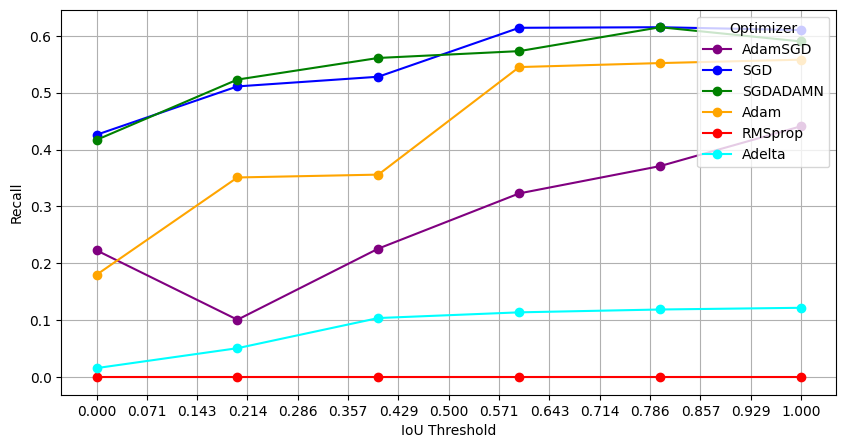

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_points = len(recall_values_ADAMNSGD)  # Adjust this if the length varies among your arrays

# Generate IoU thresholds to match the number of recall data points
iou_thresholds = np.linspace(0, 1, 6)

plt.figure(figsize=(10, 5))

# Plot each optimizer with points and connected lines
plt.plot(iou_thresholds, recall_values_ADAMNSGD, marker='o', linestyle='-', color='purple', label='AdamSGD')
plt.plot(iou_thresholds, recall_values_SGD, marker='o', linestyle='-', color='blue', label='SGD')
plt.plot(iou_thresholds, recall_values_SGDADAMN, marker='o', linestyle='-', color='green', label='SGDADAMN')
plt.plot(iou_thresholds, recall_values_Adam, marker='o', linestyle='-', color='orange', label='Adam')
plt.plot(iou_thresholds, recall_values_RMSprop, marker='o', linestyle='-', color='red', label='RMSprop')
plt.plot(iou_thresholds, recall_values_Adelta, marker='o', linestyle='-', color='cyan', label='Adelta')

# Customize the plot
plt.xlabel('IoU Threshold')
plt.ylabel('Recall')
plt.xticks(np.linspace(0, 1, 15))  # Set x-ticks at regular intervals for clarity
plt.grid(True)
plt.legend(title='Optimizer', loc='upper right')

plt.show()


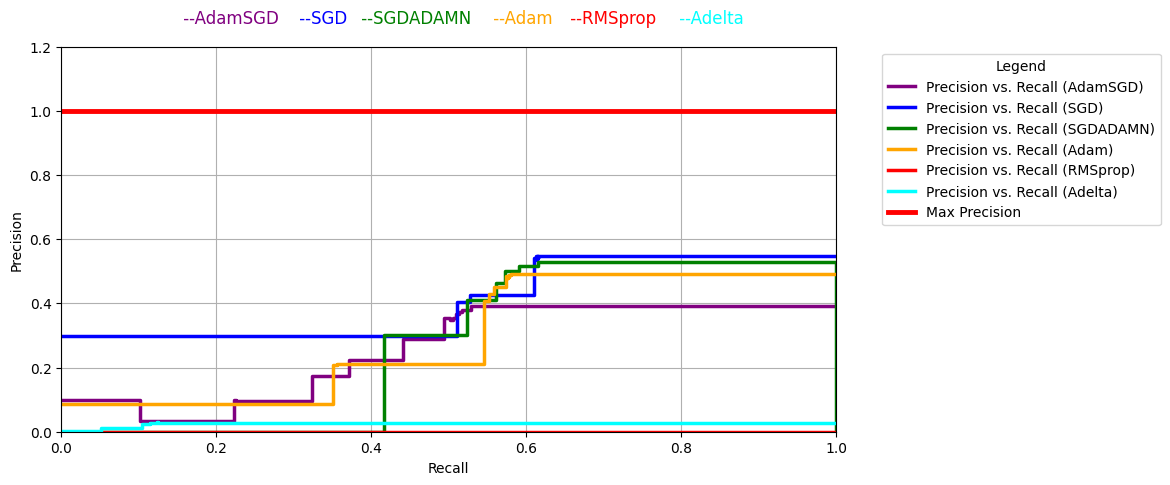

In [ ]:
import matplotlib.pyplot as plt

# Sort the data by recall since the precision-recall curve expects this.
sorted_indices_ADAMNSGD = sorted(range(len(recall_values_ADAMNSGD)), key=lambda k: recall_values_ADAMNSGD[k])
precision_values_ADAMNSGD_sorted = [precision_values_ADAMNSGD[i] for i in sorted_indices_ADAMNSGD]
recall_values_ADAMNSGD_sorted = [recall_values_ADAMNSGD[i] for i in sorted_indices_ADAMNSGD]

# To ensure the plot fully spans, check starts and ends
if recall_values_ADAMNSGD_sorted[0] > 0:
    recall_values_ADAMNSGD_sorted.insert(0, 0)
    precision_values_ADAMNSGD_sorted.insert(0, precision_values_ADAMNSGD[0])

if recall_values_ADAMNSGD_sorted[-1] < 1:
    recall_values_ADAMNSGD_sorted.append(1)
    precision_values_ADAMNSGD_sorted.append(precision_values_ADAMNSGD[-1])

# Sort the data for SGD since the precision-recall curve expects this.
sorted_indices_SGD = sorted(range(len(recall_values_SGD)), key=lambda k: recall_values_SGD[k])
precision_values_SGD_sorted = [precision_values_SGD[i] for i in sorted_indices_SGD]
recall_values_SGD_sorted = [recall_values_SGD[i] for i in sorted_indices_SGD]

# To ensure the plot fully spans, check starts and ends
if recall_values_SGD_sorted[0] > 0:
    recall_values_SGD_sorted.insert(0, 0)
    precision_values_SGD_sorted.insert(0, precision_values_SGD[0])

if recall_values_SGD_sorted[-1] < 1:
    recall_values_SGD_sorted.append(1)
    precision_values_SGD_sorted.append(precision_values_SGD[-1])

# Sort the data for SGDADAMN since the precision-recall curve expects this.
sorted_indices_SGDADAMN = sorted(range(len(recall_values_SGDADAMN)), key=lambda k: recall_values_SGDADAMN[k])
precision_values_SGDADAMN_sorted = [precision_values_SGDADAMN[i] for i in sorted_indices_SGDADAMN]
recall_values_SGDADAMN_sorted = [recall_values_SGDADAMN[i] for i in sorted_indices_SGDADAMN]

# To ensure the plot fully spans, check starts and ends
if recall_values_SGDADAMN_sorted[0] > 0:
    recall_values_SGDADAMN_sorted.insert(0, 0)
    precision_values_SGDADAMN_sorted.insert(0, precision_values_SGDADAMN[0])

if recall_values_SGDADAMN_sorted[-1] < 1:
    recall_values_SGDADAMN_sorted.append(1)
    precision_values_SGDADAMN_sorted.append(precision_values_SGDADAMN[-1])

# Sort the data for Adam since the precision-recall curve expects this.
sorted_indices_Adam = sorted(range(len(recall_values_Adam)), key=lambda k: recall_values_Adam[k])
precision_values_Adam_sorted = [precision_values_Adam[i] for i in sorted_indices_Adam]
recall_values_Adam_sorted = [recall_values_Adam[i] for i in sorted_indices_Adam]

# To ensure the plot fully spans, check starts and ends
if recall_values_Adam_sorted[0] > 0:
    recall_values_Adam_sorted.insert(0, 0)
    precision_values_Adam_sorted.insert(0, precision_values_Adam[0])

if recall_values_Adam_sorted[-1] < 1:
    recall_values_Adam_sorted.append(1)
    precision_values_Adam_sorted.append(precision_values_Adam[-1])

# Sort the data for RMSprop since the precision-recall curve expects this.
sorted_indices_RMSprop = sorted(range(len(recall_values_RMSprop)), key=lambda k: recall_values_RMSprop[k])
precision_values_RMSprop_sorted = [precision_values_RMSprop[i] for i in sorted_indices_RMSprop]
recall_values_RMSprop_sorted = [recall_values_RMSprop[i] for i in sorted_indices_RMSprop]

# To ensure the plot fully spans, check starts and ends
if recall_values_RMSprop_sorted[0] > 0:
    recall_values_RMSprop_sorted.insert(0, 0)
    precision_values_RMSprop_sorted.insert(0, precision_values_RMSprop[0])

if recall_values_RMSprop_sorted[-1] < 1:
    recall_values_RMSprop_sorted.append(1)
    precision_values_RMSprop_sorted.append(precision_values_RMSprop[-1])

# Sort the data for Adelta since the precision-recall curve expects this.
sorted_indices_Adelta = sorted(range(len(recall_values_Adelta)), key=lambda k: recall_values_Adelta[k])
precision_values_Adelta_sorted = [precision_values_Adelta[i] for i in sorted_indices_Adelta]
recall_values_Adelta_sorted = [recall_values_Adelta[i] for i in sorted_indices_Adelta]

# To ensure the plot fully spans, check starts and ends
if recall_values_Adelta_sorted[0] > 0:
    recall_values_Adelta_sorted.insert(0, 0)
    precision_values_Adelta_sorted.insert(0, precision_values_Adelta[0])

if recall_values_Adelta_sorted[-1] < 1:
    recall_values_Adelta_sorted.append(1)
    precision_values_Adelta_sorted.append(precision_values_Adelta[-1])

# Create the step plot for the precision-recall curve
plt.figure(figsize=(10, 5))

# Plot for AdamSGD
plt.step(recall_values_ADAMNSGD_sorted, precision_values_ADAMNSGD_sorted, where='post', color='purple', linewidth=2.5, label='Precision vs. Recall (AdamSGD)')

# Plot for SGD
plt.step(recall_values_SGD_sorted, precision_values_SGD_sorted, where='post', color='blue', linewidth=2.5, label='Precision vs. Recall (SGD)')

# Plot for SGDADAMN
plt.step(recall_values_SGDADAMN_sorted, precision_values_SGDADAMN_sorted, where='post', color='green', linewidth=2.5, label='Precision vs. Recall (SGDADAMN)')

# Plot for Adam
plt.step(recall_values_Adam_sorted, precision_values_Adam_sorted, where='post', color='orange', linewidth=2.5, label='Precision vs. Recall (Adam)')

# Plot for RMSprop
plt.step(recall_values_RMSprop_sorted, precision_values_RMSprop_sorted, where='post', color='red', linewidth=2.5, label='Precision vs. Recall (RMSprop)')

# Plot for Adelta
plt.step(recall_values_Adelta_sorted, precision_values_Adelta_sorted, where='post', color='cyan', linewidth=2.5, label='Precision vs. Recall (Adelta)')

# Customize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')

# Title for AdamSGD
plt.text(0.15, 1.05, ' --AdamSGD', color='purple', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGD
plt.text(0.30, 1.05, ' --SGD', color='blue', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for SGDADAMN
plt.text(0.38, 1.05, ' --SGDADAMN', color='green', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adam
plt.text(0.55, 1.05, ' --Adam', color='orange', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for RMSprop
plt.text(0.65, 1.05, ' --RMSprop', color='red', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

# Title for Adelta
plt.text(0.79, 1.05, ' --Adelta', color='cyan', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)


plt.xlim(0, 1)
plt.ylim(0, 1.2)
plt.grid(True)

# Draw a horizontal line at y=1
plt.axhline(y=1, color='red', linestyle='-', linewidth=3.5, label='Max Precision')

# Enhance the legend to include stylistic references
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [29]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [43]:
# pick one image from the test set
img, target = dataset_test[120]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

predicted #boxes:  tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10,  5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10,  5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10], device='cuda:0')
real #boxes:  tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


EXPECTED OUTPUT


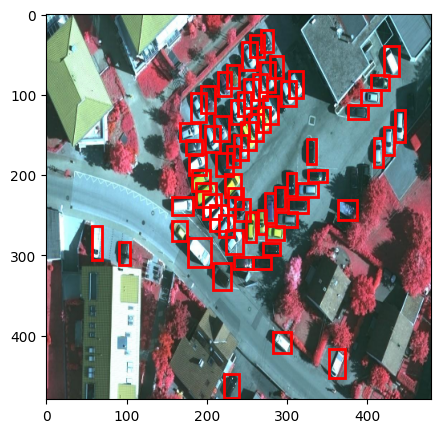

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def plot_img_bbox(img, target):
    # Convert PIL Image to NumPy array if not already an array or tensor
    if not isinstance(img, (np.ndarray, torch.Tensor)):
        img_array = np.array(img)
    else:
        img_array = img

    # Handle PyTorch tensors specifically
    if isinstance(img_array, torch.Tensor):
        # Check device and move to CPU if necessary
        if img_array.is_cuda:
            img_array = img_array.cpu()
        # Convert to a NumPy array and adjust channels from CHW to HWC if needed
        img_array = img_array.permute(1, 2, 0).numpy()

    # Plotting setup
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    ax.imshow(img_array)

    # Plot each bounding box
    for box in target['boxes']:
        # Ensure the box is on CPU and a NumPy array
        if isinstance(box, torch.Tensor):
            box = box.cpu().numpy()
        # Calculate dimensions
        x, y, w, h = box
        width, height = w - x, h - y
        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()

print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)